# Binary Cross Entropy and Mean Squared Loss Comparison: Part 2

We continue comparing and exploring differences between the functions for classification loss. In part one, 
we focused on one dataset example with 1000 cases and one feature. Where the search for the logistic regression parameters minimizing the classification loss was performed by gradient descent algorithm. 

The mean square error loss function has a global minimum, but has flat regions that can trap trajectory of gradient descent not allowing it to reach the global minimum. In general the gradient descent is slow with the mean squared error loss compared with the binary cross entropy loss. 

In part two, consider the mini-batch gradient descent. We experiment with various mini-batch sizes. For this purpose we plot the surface and contours for both loss functions using the mini-batch. 

mini-batch gradient descent we study the effect of:

1. mini-batch size.
2. learning rate
3. initial parameters. 

Later, we will consider different samples, where we change the degree of overlap of the classes,
having imbalanced classes. Imbalance is reflected in two ways:
1. number of cases per class
2. spread of cases per class, in the sense that one class may have a larger standard deviation, while the other have a smaller standard deviation.

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn import datasets
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


import utils
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [39]:
import utils_mb 
from utils_mb import *

In [42]:
import importlib
importlib.reload(utils_mb)

<module 'utils_mb' from 'C:\\Users\\Hala\\Documents\\DeepLearning\\DLNHp\\ML_training_git\\CE_MSE_comparison\\utils_mb.py'>

### Create the dataset 

We create the dataset that we are working with using scikit-learn tool. 
For visualzation purposes we want only one feature. 

This is the same dataset we used in part one. 

In [2]:
X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=1,
                   random_state=0)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4, random_state = 1235)

(1000, 1)


Visualization of the dataset. 

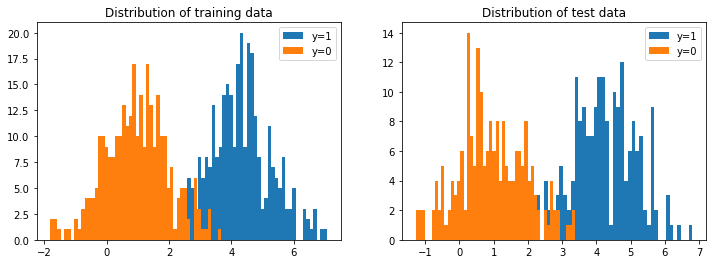

In [3]:
plt.subplots(1,2, figsize = (12,4))
plt.subplot(121)
plt.hist(X_train[y_train==1], bins = 50)
plt.hist(X_train[y_train==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of training data')

plt.subplot(122)
plt.hist(X_test[y_test==1], bins = 50)
plt.hist(X_test[y_test==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of test data')
plt.show()

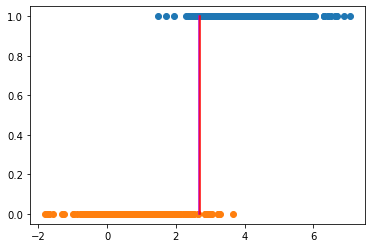

In [4]:
plt.scatter(X_train[y_train==1], y_train[y_train==1])
plt.scatter(X_train[y_train==0], y_train[y_train==0])
plt.plot([2.668, 2.668], [0, 1], 'm')
plt.plot([2.71, 2.71], [0,1], 'r')

The hypothesis function has the form:
$$ h_\theta(x) = \frac{1}{1+\exp(-(\theta_0 + \theta_1 x))}$$

to account for the intercept term in $\theta_0 + \theta_1 x$ we add a column of ones to the data matrix X

In [5]:
X_train_o = np.hstack((np.ones((X_train.shape[0],1)),X_train))
X_test_o = np.hstack((np.ones((X_test.shape[0],1)),X_test))

We define below the cross entropy cost function and mean square error cost function. 

For visualization of the cross entropy I needed to modify the sigmoid function. The logarithm of sigmoid when its value is 0.0 or the logarithm of 1-sigmoid when the sigmoid value is 1.0, becomes `-inf`. To avoid these cases. I modify the sigmoid function as in part one.

In [6]:
def costFunction(theta, X, y):
    '''
    We define here the cross entropy loss function
    takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(X)  
    
    #initialize loss J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    z = np.dot(theta,X.T)
    pred = sigmoid(z)
    
    # for visualization purposes we do not want the pred
    # to take 1 or 0 values so that the log(pre) and 
    # log(1-pred) do not taake -inf values. 
    pred[pred > 0.999] = pred[pred>0.999] - 1e-10
    pred[pred < 0.001] = pred[pred<0.001] + 1e-10
    
    # cross entropy loss
    J = (-1/m)*((np.dot(y,np.log(pred)))+ np.dot(1-y,np.log(1-pred))) 
    
    # the gradient of the J with respect to theta
    grad = (1/m) * np.dot((pred-y).T,X)
    
    
    return J, grad


def costFunction_MSE(theta, X,y):
    '''
    We define here the mean squared error loss function.
    it takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(X)
    
    #initialize J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    
    z = np.dot(theta,X.T)
    pred = sigmoid(z)
    
    J = (1/(2*m))* np.dot(y-pred, y-pred)
    
    # gradient of J with respect to theta has extra
    # step of computing h'
    hp = sigmoid_grad(z)
    grad = (-1/m) * np.dot((hp*(y-pred)).T,X)
    
    return J, grad


Below we define the function to make the mini-batches and the gradient descent alogrithm that updates the parameters using the gradinet of the loss function per minibatch (rather than the gradient loss using the whole data set at once). This process repeats and iterates over the minibatches for the assigned number of epochs (iterations).  

The generated dataset is shuffled, therefore we do not shuffle again. 

In [7]:
def make_mini_batches(X,y,batch_size):
    m = len(X)
    num_batches = m // batch_size
    mini_batches = []
    for k in range(num_batches):
        X_mini_batch = X[k*batch_size:(k+1)*batch_size,:]
        y_mini_batch = y[k*batch_size:(k+1)*batch_size]
        mini_batches.append((X_mini_batch,y_mini_batch))
    if m % batch_size != 0:
        X_mini_batch = X[num_batches * batch_size:,]
        y_mini_batch = y[num_batches * batch_size:]
        mini_batches.append((X_mini_batch, y_mini_batch))
    return mini_batches

def mini_bGD(costFunc, X, y, theta, batch_size, alpha, epochs):
    J_hist = []
    theta_hist = []
    #works faster when included inside the loop
    mini_batches = make_mini_batches(X,y, batch_size)
            
    for epoch in range(epochs):
        for mini_b in mini_batches:
            X,y = mini_b
            J, grad = costFunc(theta, X, y)
            theta = theta - alpha * grad
        #save results per epoch
        J_hist.append(J)
        theta_hist.append(theta)
        # check theta is improving
        if epoch > 100:
            theta_step = theta_hist[-2] - theta_hist[-1]
        
            # stop if improvement in theta is at machine epsilon scale
            if (abs(theta_step[0]) < 1/(2**50)) & (abs(theta_step[1]) < 1/(2**50)):
                print('early stop due to theta_step close to machine epsilon :', theta_step) 
                return theta, J_hist, theta_hist
        
        
        if epoch % 10000 == 0:
            print('epoch : {},  theta : {},  loss : {:0.8f} '.format(epoch, theta, J))
    return theta, J_hist, theta_hist        

In [6]:
model_hist_bce = {}
model_hist_mse = {}

In [7]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 0.1
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', np.mean(J_hist[-1:]))


epoch : 0,  theta : [-0.26778468  0.42099572],  loss : 0.49175743 
epoch : 10000,  theta : [-9.53257978  3.56518462],  loss : 0.04561741 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mbGD using 100000 epochs, took 1.1026 minutes
theta converged to:  [-9.53257978  3.56518462]
desicion boundary : x >=  2.67379695741601
loss at convergence :  0.04561741055923897


In [8]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 1.0
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-2.19839486  1.11036071],  loss : 0.27005599 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 0.1163 minutes
theta converged to:  [-9.67095441  3.56125039]
desicion boundary : x >=  2.7156064146526218
loss at convergence :  0.04416177257071613


In [9]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 0.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-1.33416271  0.78670206],  loss : 0.31969330 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mbGD using 100000 epochs, took 0.2253 minutes
theta converged to:  [-9.57555909  3.55316476]
desicion boundary : x >=  2.6949381015158314
loss at convergence :  0.04498358886016701


In [10]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 1.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_bce['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-2.86931324  1.23717588],  loss : 0.21738704 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 0.0802 minutes
theta converged to:  [-9.80353998  3.61522502]
desicion boundary : x >=  2.7117371435611464
loss at convergence :  0.04457767698751669


In [11]:
for key in model_hist_bce:
    model_hist_bce[key]['actual_epochs'] = len(model_hist_bce[key]['loss'])
    print(key+'. Actual number of epochs :',len(model_hist_bce[key]['loss']))

epochs 100000 lr 0.1 batch_size 32. Actual number of epochs : 12242
epochs 100000 lr 1.0 batch_size 32. Actual number of epochs : 1311
epochs 100000 lr 0.5 batch_size 32. Actual number of epochs : 2650
epochs 100000 lr 1.5 batch_size 32. Actual number of epochs : 885


In [12]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 0.1
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-0.03323039  0.21787237],  loss : 0.09635139 
epoch : 10000,  theta : [-8.48103068  3.18284108],  loss : 0.00589742 
epoch : 20000,  theta : [-8.73694994  3.27619364],  loss : 0.00566110 
epoch : 30000,  theta : [-8.77466245  3.28996408],  loss : 0.00562727 
epoch : 40000,  theta : [-8.78060249  3.29213337],  loss : 0.00562197 
epoch : 50000,  theta : [-8.78154737  3.29247845],  loss : 0.00562112 
epoch : 60000,  theta : [-8.78169791  3.29253343],  loss : 0.00562099 
epoch : 70000,  theta : [-8.7817219   3.29254219],  loss : 0.00562097 
epoch : 80000,  theta : [-8.78172572  3.29254359],  loss : 0.00562096 
epoch : 90000,  theta : [-8.78172633  3.29254381],  loss : 0.00562096 
mbGD using 100000 epochs, took 5.1455 minutes
theta converged to:  [-8.78172643  3.29254384]
desicion boundary : x >=  2.6671555016578083
loss at convergence :  0.005620964220159027


In [13]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 1.0
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-0.6989972   0.48061422],  loss : 0.06296251 
epoch : 10000,  theta : [-8.78115032  3.27275551],  loss : 0.00553131 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 1.1959 minutes
theta converged to:  [-8.78115034  3.27275551]
desicion boundary : x >=  2.6831061170685127
loss at convergence :  0.005531313048425041


In [14]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 0.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-0.34811522  0.37503458],  loss : 0.07788304 
epoch : 10000,  theta : [-8.77899205  3.28305911],  loss : 0.00558657 
epoch : 20000,  theta : [-8.77915962  3.28312025],  loss : 0.00558642 
epoch : 30000,  theta : [-8.77915963  3.28312025],  loss : 0.00558642 
early stop due to theta_step close to machine epsilon : [ 0.0000000e+00 -4.4408921e-16]
mbGD using 100000 epochs, took 2.4158 minutes
theta converged to:  [-8.77915963  3.28312025]
desicion boundary : x >=  2.674029263117614
loss at convergence :  0.005586420301818916


In [15]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
epochs = 100000
batch_size = 32
lr = 1.5
start = time.time()
theta, J_hist, theta_hist = mini_bGD(costFunction_MSE, X_train_o, y_train, theta_0, batch_size,lr, epochs)
model_hist_mse['epochs '+str(epochs)+' lr '+str(lr)+' batch_size '+str(batch_size)]={
    'epochs' : epochs, 
    'LR' : lr,
    'batch_size': batch_size,
    'theta' : theta,
    'loss' : J_hist,
    'theta_hist': theta_hist
}
print('mbGD using {0:d} epochs, took {1:3.4f} minutes'.format(epochs, (time.time()-start)/60.0))
print('theta converged to: ', theta)
print('desicion boundary : x >= ',-theta[0]/theta[1])
print('loss at convergence : ', J_hist[-1])


epoch : 0,  theta : [-0.98703549  0.58476789],  loss : 0.05397277 
epoch : 10000,  theta : [-8.78970788  3.26456259],  loss : 0.00546546 
early stop due to theta_step close to machine epsilon : [0. 0.]
mbGD using 100000 epochs, took 0.8322 minutes
theta converged to:  [-8.78970788  3.26456259]
desicion boundary : x >=  2.692461130911606
loss at convergence :  0.005465459975557158


In [16]:
#MSE actual epochs: 
for key in model_hist_mse:
    model_hist_mse[key]['actual_epochs'] = len(model_hist_mse[key]['loss'])
    print(key+'. Actual number of epochs :',len(model_hist_mse[key]['loss']))

epochs 100000 lr 0.1 batch_size 32. Actual number of epochs : 100000
epochs 100000 lr 1.0 batch_size 32. Actual number of epochs : 15009
epochs 100000 lr 0.5 batch_size 32. Actual number of epochs : 30219
epochs 100000 lr 1.5 batch_size 32. Actual number of epochs : 10494


In [18]:
iterations_info = pd.DataFrame(columns = ['model','LR','num_iter'])
i = 0
for key in model_hist_bce:
    iterations_info.loc[i,'model'] = 'Cross Entropy'
    iterations_info.loc[i,'LR'] = model_hist_bce[key]['LR']
    iterations_info.loc[i,'num_iter'] = model_hist_bce[key]['actual_epochs']
    i += 1

for key in model_hist_mse:
    iterations_info.loc[i,'model'] = 'Mean Squared Error'
    iterations_info.loc[i,'LR'] = model_hist_mse[key]['LR']
    iterations_info.loc[i,'num_iter'] = model_hist_mse[key]['actual_epochs']
    i += 1

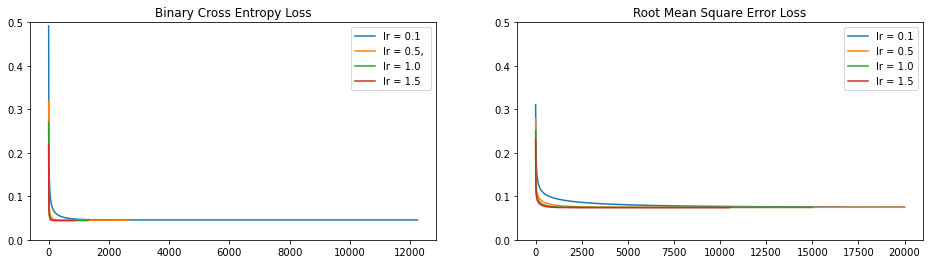

In [21]:
plt.subplots(1,2,figsize=(16,4))
plt.subplot(1,2,1)
key_name = 'epochs 100000 lr 0.1 batch_size 32'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
key_name = 'epochs 100000 lr 0.5 batch_size 32'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
key_name = 'epochs 100000 lr 1.0 batch_size 32'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
key_name = 'epochs 100000 lr 1.5 batch_size 32'
plt.plot(model_hist_bce[key_name]['loss'][:20000])
plt.ylim((0,.5))
plt.legend(['lr = 0.1', 'lr = 0.5, ','lr = 1.0', 'lr = 1.5'])
plt.title('Binary Cross Entropy Loss')

plt.subplot(1,2,2)
key_name = 'epochs 100000 lr 0.1 batch_size 32'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
key_name = 'epochs 100000 lr 0.5 batch_size 32'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
key_name = 'epochs 100000 lr 1.0 batch_size 32'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
key_name = 'epochs 100000 lr 1.5 batch_size 32'
plt.plot(np.sqrt(model_hist_mse[key_name]['loss'][:20000]))
plt.ylim((0,.5))
plt.legend(['lr = 0.1', 'lr = 0.5', 'lr = 1.0', 'lr = 1.5'])
plt.title('Root Mean Square Error Loss')

plt.show()

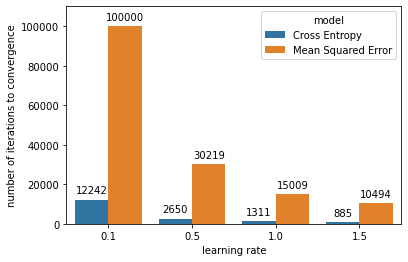

In [46]:
#source of code to annotate bars
#https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
splot = sns.barplot(x='LR',y='num_iter', hue = 'model',data = iterations_info)
for p in splot.patches:
    splot.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel('learning rate')
plt.ylabel('number of iterations to convergence')
plt.ylim((0,110000))
plt.show()

The experiments above show that minibatch GD with batch size of 32 converge to the same respecive values using GD. The MSE loss function converge significantly slower than the binary cross enropy loss function. 

Moreover, the larger the learning rate the faster the DG converges.

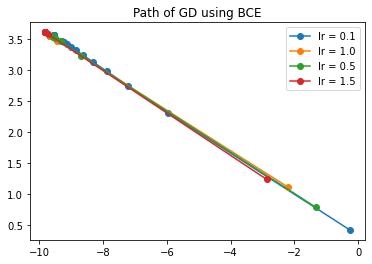

In [22]:
for key in model_hist_bce:
    theta_hist = model_hist_bce[key]['theta_hist']
    L = len(theta_hist)
    M = min(L, 1000)
    
    th_short_list = [theta_hist[i] for i in range(0,M,100)]
    [th_short_list.append(theta_hist[i]) for i in range(M,L,2000)]

    ths11 = []
    ths22 = []

    for i in range(len(th_short_list)):
        ths11.append(th_short_list[i][0])
        ths22.append(th_short_list[i][1])
    plt.plot(ths11,ths22,'o-')
    #plt.ylim((3,4))
    #plt.xlim((-10,-8))
    
plt.legend(['lr = 0.1', 'lr = 1.0', 'lr = 0.5', 'lr = 1.5'])
plt.title ('Path of GD using BCE')
plt.show()

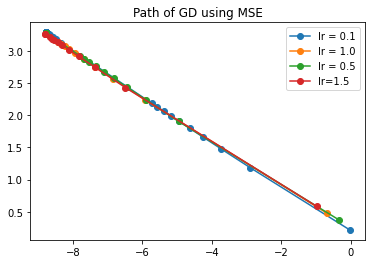

In [23]:
for key in model_hist_mse:
    theta_hist = model_hist_mse[key]['theta_hist']
    L = len(theta_hist)
    th_mse_short_list = [theta_hist[i] for i in range(0,1000,100)]
    [th_mse_short_list.append(theta_hist[i]) for i in range(8000,L,2000)]

    ths11 = []
    ths22 = []

    for i in range(len(th_mse_short_list)):
        ths11.append(th_mse_short_list[i][0])
        ths22.append(th_mse_short_list[i][1])
    plt.plot(ths11,ths22,'o-')
    #plt.ylim((3,4))
    #plt.xlim((-9,-8))
    
plt.legend(['lr = 0.1', 'lr = 1.0', 'lr = 0.5', 'lr=1.5'])
plt.title('Path of GD using MSE')
plt.show()

In [24]:
key = 'epochs 100000 lr 1.0 batch_size 32'
theta_hist = model_hist_bce[key]['theta_hist']
L = len(theta_hist)
th_short_list = [theta_hist[i] for i in range(0,1000,100)]
[th_short_list.append(theta_hist[i]) for i in range(8000,L,2000)]

#optimal value
theta_ce2 = theta_hist[-1]

ths1 = []
ths2 = []

for i in range(len(th_short_list)):
    ths1.append(th_short_list[i][0])
    ths2.append(th_short_list[i][1])

In [25]:
key = 'epochs 100000 lr 1.0 batch_size 32'
theta_hist = model_hist_mse[key]['theta_hist']
L = len(theta_hist)
th_mse_short_list = [theta_hist[i] for i in range(0,1000,100)]
[th_mse_short_list.append(theta_hist[i]) for i in range(8000,L,2000)]

theta_mse2 = theta_hist[-1]
ths11 = []
ths22 = []

for i in range(len(th_mse_short_list)):
    ths11.append(th_mse_short_list[i][0])
    ths22.append(th_mse_short_list[i][1])

In [62]:
mini_batches = make_mini_batches(X_train_o,y_train, batch_size)


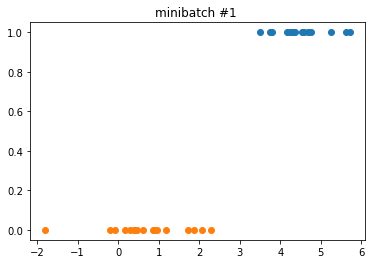

In [133]:
xx, yy = mini_batches[1]
plt.scatter(xx[yy==1,1], yy[yy==1])
plt.scatter(xx[yy==0,1], yy[yy==0])
plt.title('minibatch #1 ')
plt.show()

In [66]:
# good view using x1: [-12,6], x2: [-6, 12]
x1 = np.sort(np.concatenate((np.linspace(-80,80,401),np.array(ths1))))
x2 = np.sort(np.concatenate((np.linspace(-80,80,401),np.array(ths2))))
x12, x21 = np.meshgrid(x1, x2)


J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, xx, yy)

In [ ]:
Js12 = np.zeros(len(ths1))
for i in range(len(ths1)):
    theta = np.array([ths1[i], ths2[i]])
    Js12[i], _ = costFunction(theta, xx, yy)

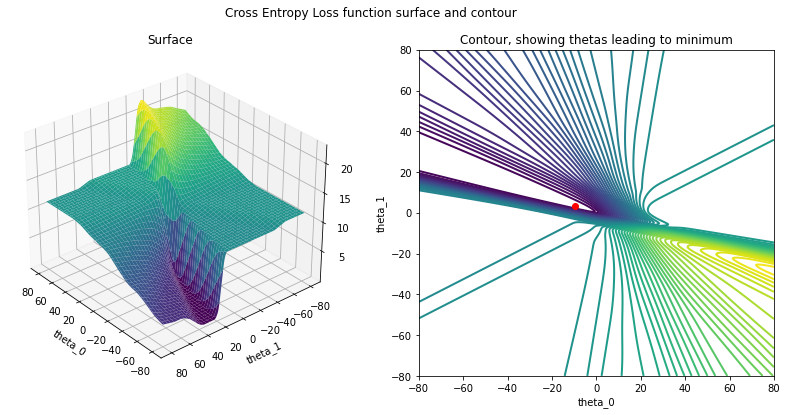

In [75]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [ ]:
K12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, xx, yy)

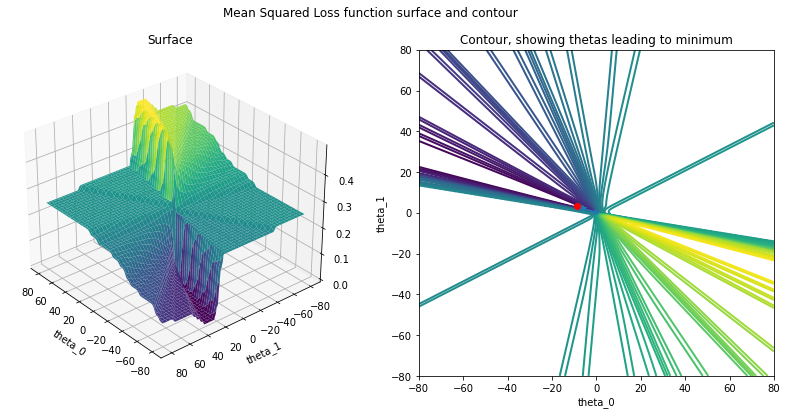

In [132]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, K12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Mean Squared Loss function surface and contour')
plt.show()

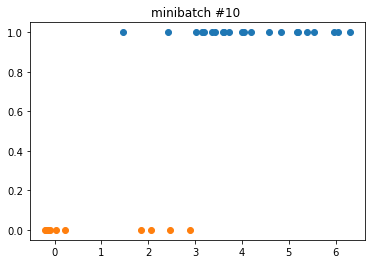

In [97]:
xx2, yy2 = mini_batches[10]
plt.scatter(xx2[yy2==1,1], yy2[yy2==1])
plt.scatter(xx2[yy2==0,1], yy2[yy2==0])
plt.title('minibatch #10 ')
plt.show()

In [ ]:
J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, xx2, yy2)

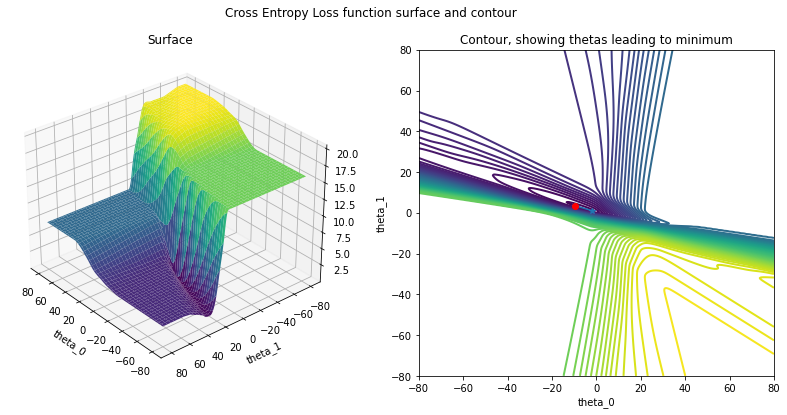

In [122]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [134]:
K12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, xx2, yy2)

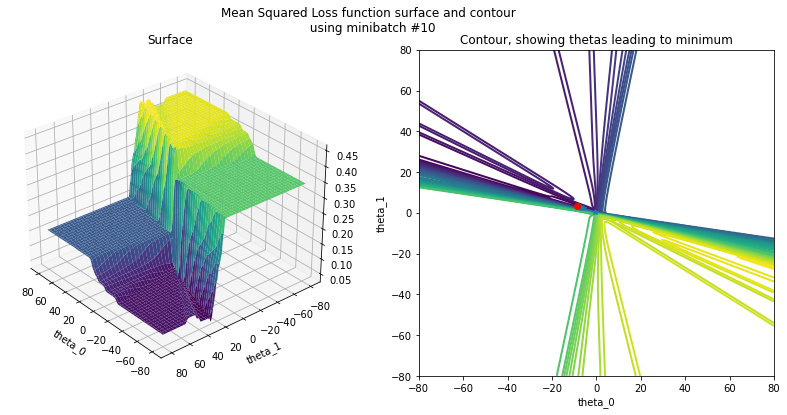

In [135]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, K12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Mean Squared Loss function surface and contour \n using minibatch #10')
plt.show()

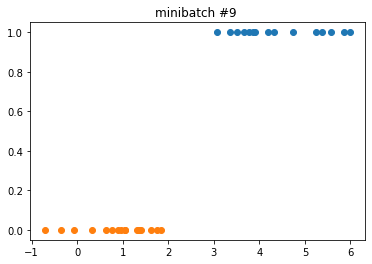

In [120]:
xx3, yy3 = mini_batches[9]
plt.scatter(xx3[yy3==1,1], yy3[yy3==1])
plt.scatter(xx3[yy3==0,1], yy3[yy3==0])
plt.title('minibatch #9 ')
plt.show()

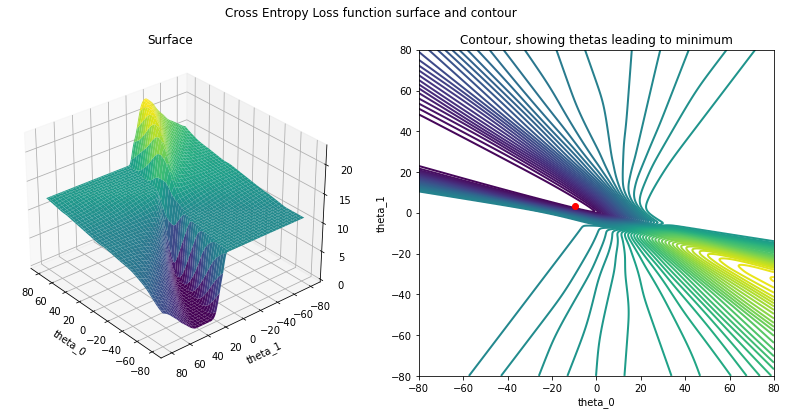

In [118]:


J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, xx3, yy3)

#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [136]:
K12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, xx3, yy3)

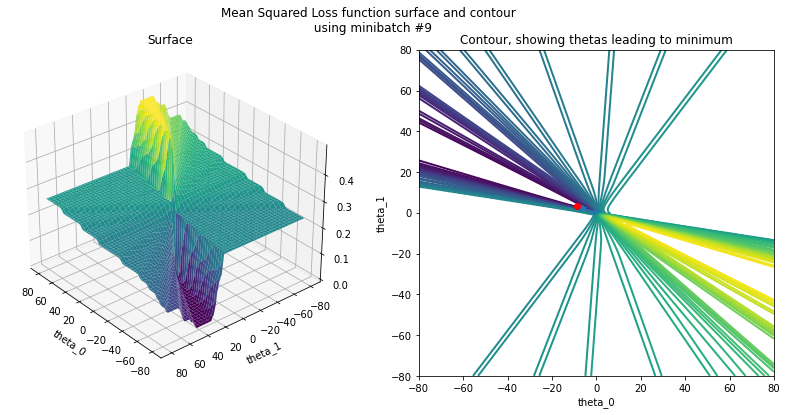

In [137]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, K12, cmap='viridis', linewidth=0.2)
ax.view_init(30,140)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, K12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Mean Squared Loss function surface and contour \n using minibatch #9')
plt.show()

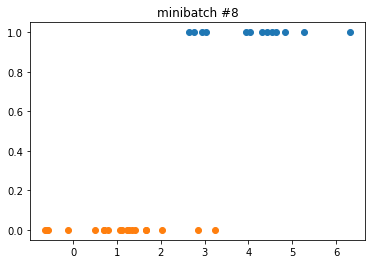

In [166]:
batch_number = 8
xx4, yy4 = mini_batches[batch_number]
plt.scatter(xx4[yy4==1,1], yy4[yy4==1])
plt.scatter(xx4[yy4==0,1], yy4[yy4==0])
plt.title('minibatch #'+str(batch_number))
plt.show()

# Testing with challenging initial parameter values

We start with testing some values that we checked in part 1 where we used the whole batch. Here we select with few test case.

In [26]:
theta_mse2

array([-8.78115034,  3.27275551])

theta_0_lcm  [10.5 -5.5]
epoch : 0,  theta : [10.24486116 -5.896869  ],  loss : 0.44013032 
epoch : 10000,  theta : [-10.23781684  -3.22760196],  loss : 0.22916736 
epoch : 20000,  theta : [-10.32956143  -3.0697975 ],  loss : 0.22916702 
epoch : 30000,  theta : [-10.38235395  -2.97861127],  loss : 0.22916691 
epoch : 40000,  theta : [-10.41947506  -2.91411142],  loss : 0.22916685 
epoch : 50000,  theta : [-10.44806429  -2.86407819],  loss : 0.22916681 
epoch : 60000,  theta : [-10.47127147  -2.82313019],  loss : 0.22916679 
epoch : 70000,  theta : [-10.49076771  -2.78841708],  loss : 0.22916677 
epoch : 80000,  theta : [-10.50754708  -2.75824599],  loss : 0.22916676 
epoch : 90000,  theta : [-10.52224932  -2.73152908],  loss : 0.22916675 
mini batch GD tool 6.824 minutes
Minimizing theta (lr = 1.0)  [-10.53530931  -2.70752813]
Loss value (lr = 1.0)  0.22916674148167027
Computations for surface plots time 1.173 minutes


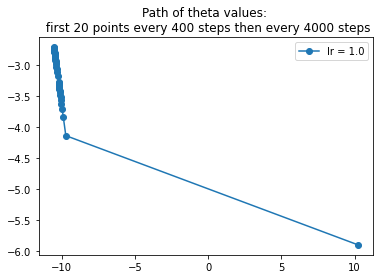

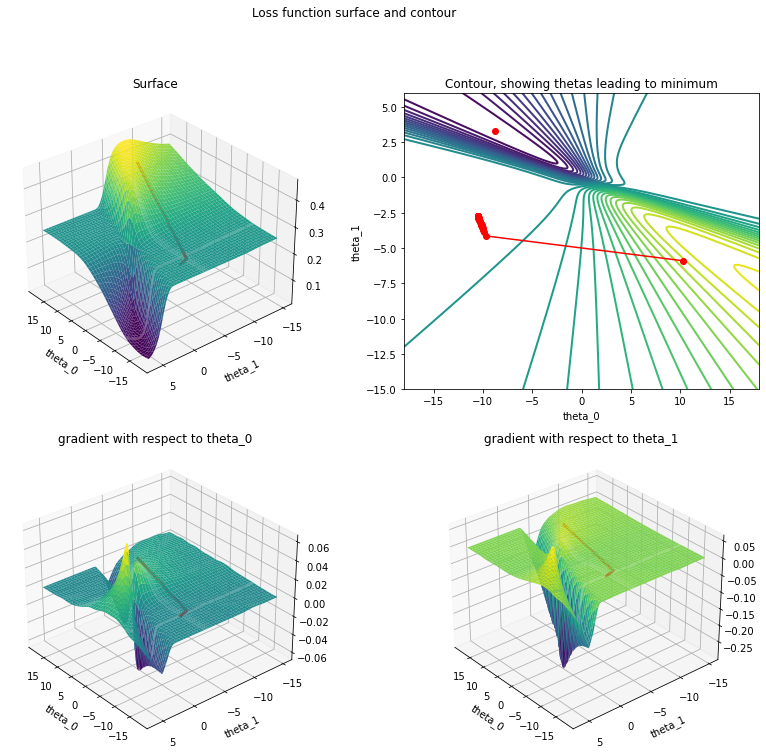

In [41]:
#matches example 4 in part 1
theta_0_lcm = np.array([10.5, -5.5])
iterations = 100000
batch_size = 32
xmin, xmax = -18, 18
ymin, ymax = -15, 6
utils_mb.local_min_plots(costFunction_MSE, X_train_o, y_train, theta_0_lcm, batch_size, \
                         iterations, xmin, xmax, ymin, ymax, theta_mse2)

theta_0_lcm  [13. -5.]
epoch : 0,  theta : [13.03588914 -4.81697566],  loss : 0.47613596 
epoch : 10000,  theta : [13.01294312 -1.27815663],  loss : 0.27082682 
epoch : 20000,  theta : [10.7805824  -1.06386947],  loss : 0.27079324 
epoch : 30000,  theta : [-8.78114984  3.27275533],  loss : 0.00553131 
early stop due to theta_step close to machine epsilon : [0. 0.]
mini batch GD took 2.836 minutes
Minimizing theta (lr = 1.0)  [-8.78115034  3.27275551]
Loss value (lr = 1.0)  0.005531313048425041
Computations for surface plots time 1.202 minutes


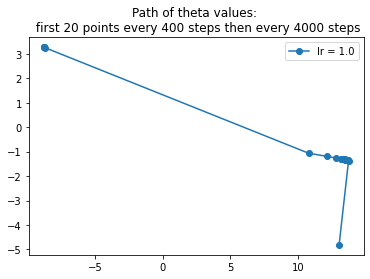

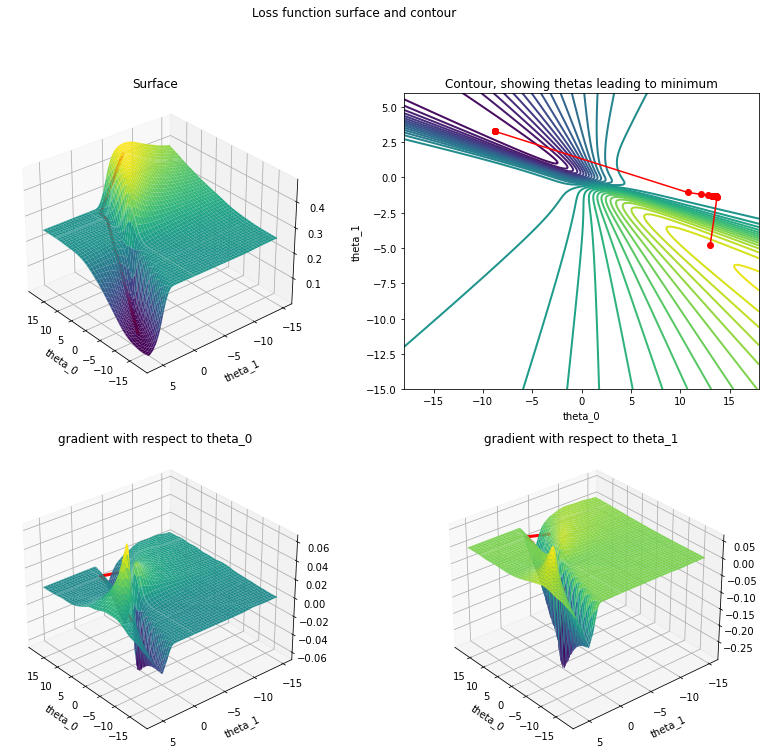

In [43]:
#matches example 4 in part 1
theta_0_lcm = np.array([13.0, -5.0])
iterations = 100000
batch_size = 32
xmin, xmax = -18, 18
ymin, ymax = -15, 6
utils_mb.local_min_plots(costFunction_MSE, X_train_o, y_train, theta_0_lcm, batch_size, \
                         iterations, xmin, xmax, ymin, ymax, theta_mse2)